In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [106]:
class Parameters(object):
    '''Parameters defining a PARSEC airfoil'''   
    def __init__(self, x):

        if x.size > 6:
            print("5d np array expected")

        front_radius        = x[0]
        x_cross_section     = x[1]
        cross_section_width = x[2]
        sides_curve         = x[3]
        rear_angle          = x[4]
        trunc               = 1
        if x.size > 5:
            trunc               = x[5]
            

        self.r_le       = front_radius              # Leading edge radius
        self.X_up       = x_cross_section           # Upper crest location X coordinate
        self.Z_up       = cross_section_width       # Upper crest location Z coordinate
        self.Z_XX_up    = -sides_curve              # Upper crest location curvature
        self.X_lo       = x_cross_section           # Lower crest location X coordinate
        self.Z_lo       = -cross_section_width      # Lower crest location Z coordinate
        self.Z_XX_lo    = sides_curve               # Lower crest location curvature
        self.Z_te       = 0 # static                # Trailing edge Z coordinate
        self.dZ_te      = 0 # static                # Trailing edge thickness
        self.alpha_te   = 0 # static                # Trailing edge direction angle
        self.beta_te    = rear_angle #(radians)     # Trailing edge wedge angle
        self.P_mix      = 1.0                       # Blending parameter
        self.trunc      = min(trunc,1)              # Where we truncate

In [107]:
class Coefficients(object):
    '''
    Credit for this class goes to
    https://github.com/mbodmer/libairfoil
    This class calculates the equation systems which define the coefficients
    for the polynomials given by the parsec airfoil parameters.
    '''
    def __init__(self, parsec_params):
        self.params = Parameters(parsec_params)
        self._a_up = self._calc_a_up(self.params)
        self._a_lo = self._calc_a_lo(self.params)
    
    def a_up(self):
        '''Returns coefficient vector for upper surface'''
        return self._a_up
    
    def a_lo(self):
        '''Returns coefficient vector for lower surface'''
        return self._a_lo
    
    def _calc_a_up(self, parsec_params):
        Amat = self._prepare_linsys_Amat(parsec_params.X_up)
        Bvec = np.array([parsec_params.Z_te, parsec_params.Z_up,
                            math.tan(parsec_params.alpha_te - parsec_params.beta_te/2),
                            0.0, parsec_params.Z_XX_up, math.sqrt(2*parsec_params.r_le)]) 
        return np.linalg.solve(Amat, Bvec)
    
    def _calc_a_lo(self, parsec_params):
        Amat = self._prepare_linsys_Amat(parsec_params.X_lo)
        Bvec = np.array([parsec_params.Z_te, parsec_params.Z_lo,
                            math.tan(parsec_params.alpha_te + parsec_params.beta_te/2),
                            0.0, parsec_params.Z_XX_lo, -math.sqrt(2*parsec_params.r_le)])
        return np.linalg.solve(Amat, Bvec)
    
    def _prepare_linsys_Amat(self, X):
        return np.array(
            [[1.0,           1.0,          1.0,         1.0,          1.0,          1.0        ],
             [X**0.5,        X**1.5,       X**2.5,      X**3.5,       X**4.5,       X**5.5     ],
             [0.5,           1.5,          2.5,         3.5,          4.5,          5.5        ],
             [0.5*X**-0.5,   1.5*X**0.5,   2.5*X**1.5,  3.5*X**2.5,   4.5*X**3.5,   5.5*X**4.5 ],
             [-0.25*X**-1.5, 0.75*X**-0.5, 3.75*X**0.5, 8.75*X**1.5, 15.75*X**2.5, 24.75*X**3.5],
             [1.0,           0.0,          0.0,         0.0,          0.0,          0.0        ]])

In [108]:
class Airfoil(object):
    '''
    Credit for this class goes to
    https://github.com/mbodmer/libairfoil
    Airfoil defined by PARSEC Parameters
    '''
    def __init__(self, parsec_params):
        self._coeff = Coefficients(parsec_params)
        
    def Z_up(self, X):
        '''Returns Z(X) on upper surface, calculates PARSEC polynomial'''
        a = self._coeff.a_up()
        X = X * self._coeff.params.trunc
        foil = a[0]*X**0.5 + a[1]*X**1.5 + a[2]*X**2.5 + a[3]*X**3.5 + a[4]*X**4.5 + a[5]*X**5.5
        foil[-1] = 0
        return foil    
    
    def Z_lo(self, X):
        '''Returns Z(X) on lower surface, calculates PARSEC polynomial'''
        a = self._coeff.a_lo()
        X = X * self._coeff.params.trunc
        foil = a[0]*X**0.5 + a[1]*X**1.5 + a[2]*X**2.5 + a[3]*X**3.5 + a[4]*X**4.5 + a[5]*X**5.5
        foil[-1] = 0
        return foil

In [283]:
def plot_airfoil(airfoil, f=None, l=None, grid=True):
    x = np.linspace(0.0, 1.0, 150)
    foil_up = airfoil.Z_up(x)
    foil_lo = airfoil.Z_lo(x)
    topmax = np.max(foil_up)

    foil_up = foil_up * 1/(6*topmax)
    foil_lo = foil_lo * 1/(6*topmax)
    
    # plt.plot(x, foil_up, 'r--', x,foil_lo, 'b--')
    plt.plot(x, foil_up, c='b', linewidth=3)
    plt.plot(x, foil_lo, c='b', linewidth=3)
    
    
    plt.xlim(-.1, 1.1)
    plt.ylim(-.3, .3)
    if l is not None:
        plt.xlabel(l)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(grid)
    if f is None:
        plt.show()
    else:
        plt.savefig(f)
    plt.close()

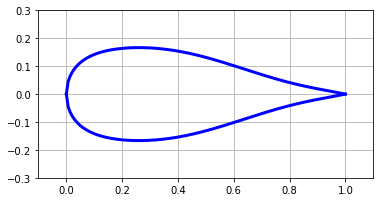

In [284]:
params = [0.4, 0.26, 0.26, 2.2, np.pi/5]
params = np.array(params)
airfoil = Airfoil(params)
plot_airfoil(airfoil)

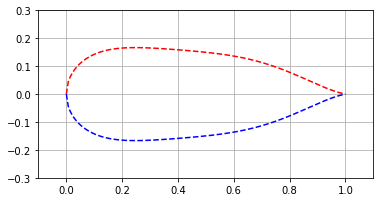

In [113]:
params = [0.4, 0.247, 0.279, 1.985, 0.647]
params = np.array(params)
airfoil = Airfoil(params)
plot_airfoil(airfoil)

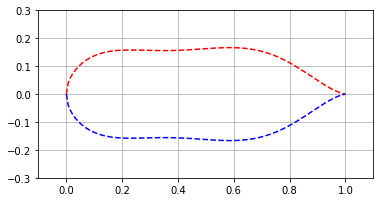

In [114]:
params = [0.396, 0.229, 0.287, 1.99, 0.67]
params = np.array(params)
airfoil = Airfoil(params)
plot_airfoil(airfoil)

In [42]:
designs = [
[0.4, 0.26, 0.26, 2.0, 0.628],
[0.42, 0.26, 0.26, 2.0, 0.628],
[0.4, 0.273, 0.26, 2.0, 0.628],
[0.4, 0.26, 0.273, 2.0, 0.628],
[0.4, 0.26, 0.26, 2.1, 0.628],
[0.4, 0.26, 0.26, 2.0, 0.66],
[0.408, 0.265, 0.265, 2.04, 0.597],
[0.411, 0.267, 0.267, 2.056, 0.616],
[0.404, 0.263, 0.263, 2.022, 0.655],
[0.386, 0.269, 0.269, 2.071, 0.634],
[0.412, 0.262, 0.262, 2.018, 0.63],
[0.4, 0.26, 0.266, 2.05, 0.628],
[0.4, 0.266, 0.266, 2.0, 0.628],
[0.406, 0.264, 0.27, 2.028, 0.622],
[0.402, 0.261, 0.268, 2.011, 0.642],
[0.41, 0.26, 0.266, 2.0, 0.628],
[0.399, 0.26, 0.266, 1.996, 0.64],
[0.391, 0.263, 0.269, 2.023, 0.638],
[0.397, 0.264, 0.271, 1.962, 0.642],
[0.396, 0.257, 0.272, 1.997, 0.648],
[0.393, 0.252, 0.275, 1.996, 0.657],
[0.406, 0.256, 0.272, 1.963, 0.646],
[0.396, 0.255, 0.275, 1.956, 0.644],
[0.398, 0.255, 0.28, 1.954, 0.647],
[0.4, 0.247, 0.279, 1.985, 0.647],
[0.402, 0.239, 0.284, 1.997, 0.649],
[0.401, 0.249, 0.271, 2.01, 0.643],
[0.4, 0.24, 0.278, 1.969, 0.667],
[0.405, 0.239, 0.277, 2.018, 0.661],
[0.395, 0.232, 0.282, 2.033, 0.665],
[0.389, 0.22, 0.287, 2.068, 0.675],
[0.397, 0.231, 0.287, 1.995, 0.677],
[0.394, 0.223, 0.295, 1.987, 0.694],
[0.389, 0.238, 0.285, 1.978, 0.665],
[0.4, 0.22, 0.291, 1.993, 0.672],
[0.408, 0.227, 0.283, 2.017, 0.667],
[0.394, 0.235, 0.285, 1.987, 0.666],
[0.395, 0.223, 0.294, 2.033, 0.665],
[0.396, 0.227, 0.29, 2.017, 0.665],
[0.395, 0.233, 0.286, 1.991, 0.671],
[0.394, 0.234, 0.283, 2.01, 0.665],
[0.397, 0.228, 0.288, 1.99, 0.669],
[0.398, 0.237, 0.284, 1.992, 0.657],
[0.397, 0.238, 0.281, 1.978, 0.666],
[0.398, 0.235, 0.286, 1.966, 0.666],
[0.398, 0.236, 0.284, 1.974, 0.658],
[0.398, 0.235, 0.284, 1.979, 0.662],
[0.395, 0.232, 0.286, 1.989, 0.667],
[0.397, 0.231, 0.287, 1.978, 0.668],
[0.397, 0.233, 0.285, 1.984, 0.668],
[0.397, 0.232, 0.286, 1.991, 0.663],
[0.396, 0.231, 0.287, 1.991, 0.67],
[0.396, 0.229, 0.287, 1.981, 0.674],
[0.396, 0.228, 0.29, 1.987, 0.671],
[0.396, 0.229, 0.288, 1.987, 0.67],
[0.396, 0.23, 0.287, 1.989, 0.668],
[0.397, 0.23, 0.287, 1.984, 0.668],
[0.396, 0.229, 0.287, 1.99, 0.67],
[0.396, 0.229, 0.287, 1.986, 0.671],
]

objs = [
1.1093,
1.1024,
1.0895,
1.013,
1.0816,
1.1212,
1.1025,
1.1,
1.1024,
1.103,
1.1034,
1.1273,
1.108,
1.1557,
1.0844,
1.1384,
1.0787,
1.0895,
1.0776,
0.9966,
0.8868,
0.9774,
0.9913,
1.0177,
0.7869,
0.7767,
0.9051,
0.8195,
0.9031,
0.7422,
0.7652,
0.7398,
0.7642,
0.8457,
0.7746,
1.0579,
0.7236,
0.7797,
0.8605,
0.8592,
1.0154,
0.7158,
0.8386,
0.8343,
0.7379,
0.8539,
0.8576,
0.74,
0.7415,
0.8714,
0.9005,
0.7422,
0.7443,
0.8548,
0.9002,
1.0505,
0.8901,
0.7201,
0.9267,
]
    

In [115]:
def plot_anim(designs, objs):
    for i in range(len(designs)):
        params = designs[i]
        params = Parameters(np.array(params))
        airfoil = Trunc_Airfoil(params)
        iter = str(i+1)
        iter = '0'*(4-len(iter)) + iter
        filename = "./myopt/anim/iter" + iter + ".png"
        label = "Iter: " + iter + "    Obj: {:.4f}".format(objs[i])
        plot_airfoil(airfoil, f=filename, l=label)

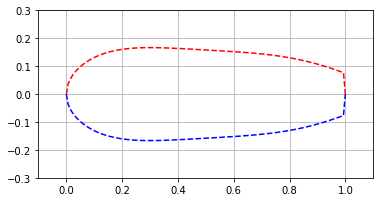

In [280]:
params = [0.397, 0.246, 0.294, 2.283, 0.611, 0.82]
params = np.array(params)
airfoil = Airfoil(params)
plot_airfoil(airfoil)

In [21]:
designs = [
    [0.4, 0.26, 0.26, 2.2, 0.628, 0.9],
[0.42, 0.26, 0.26, 2.2, 0.628, 0.9],
[0.4, 0.273, 0.26, 2.2, 0.628, 0.9],
[0.4, 0.26, 0.273, 2.2, 0.628, 0.9],
[0.4, 0.26, 0.26, 2.31, 0.628, 0.9],
[0.4, 0.26, 0.26, 2.2, 0.66, 0.9],
[0.4, 0.26, 0.26, 2.2, 0.628, 0.945],
[0.407, 0.264, 0.264, 2.237, 0.639, 0.855],
[0.382, 0.266, 0.266, 2.249, 0.642, 0.885],
[0.396, 0.268, 0.268, 2.265, 0.605, 0.88],
[0.395, 0.27, 0.27, 2.14, 0.629, 0.873],
[0.393, 0.256, 0.274, 2.23, 0.629, 0.864],
[0.39, 0.248, 0.281, 2.245, 0.629, 0.847],
[0.39, 0.265, 0.281, 2.245, 0.629, 0.847],
[0.392, 0.257, 0.277, 2.174, 0.66, 0.856],
[0.409, 0.256, 0.283, 2.165, 0.629, 0.841],
[0.401, 0.247, 0.283, 2.282, 0.643, 0.842],
[0.387, 0.247, 0.295, 2.201, 0.634, 0.855],
[0.378, 0.238, 0.31, 2.182, 0.632, 0.856],
[0.39, 0.246, 0.293, 2.237, 0.647, 0.796],
[0.385, 0.24, 0.303, 2.256, 0.656, 0.743],
[0.397, 0.246, 0.294, 2.285, 0.61, 0.82],
[0.4, 0.241, 0.303, 2.34, 0.585, 0.802],
[0.401, 0.231, 0.295, 2.226, 0.635, 0.82],
[0.38, 0.232, 0.297, 2.327, 0.637, 0.819],
[0.387, 0.238, 0.294, 2.287, 0.635, 0.824],
[0.383, 0.26, 0.284, 2.286, 0.631, 0.841],
[0.397, 0.238, 0.293, 2.241, 0.634, 0.825],
[0.382, 0.241, 0.3, 2.217, 0.62, 0.814],
[0.396, 0.245, 0.287, 2.266, 0.637, 0.835],
[0.399, 0.252, 0.287, 2.205, 0.629, 0.835],
[0.396, 0.249, 0.289, 2.225, 0.63, 0.832],
[0.397, 0.242, 0.303, 2.24, 0.635, 0.808],
[0.392, 0.247, 0.286, 2.244, 0.631, 0.837],
[0.389, 0.255, 0.289, 2.245, 0.629, 0.833],
[0.391, 0.251, 0.29, 2.244, 0.63, 0.831],
[0.4, 0.248, 0.285, 2.3, 0.627, 0.795],
[0.397, 0.248, 0.287, 2.275, 0.629, 0.81],
[0.395, 0.246, 0.29, 2.264, 0.62, 0.828],
[0.397, 0.246, 0.291, 2.275, 0.624, 0.827],
[0.397, 0.247, 0.291, 2.255, 0.62, 0.826],
[0.394, 0.248, 0.292, 2.264, 0.62, 0.825],
[0.394, 0.246, 0.294, 2.261, 0.628, 0.808],
[0.392, 0.246, 0.294, 2.243, 0.622, 0.838],
[0.399, 0.247, 0.29, 2.292, 0.619, 0.807],
[0.394, 0.246, 0.293, 2.255, 0.621, 0.83],
[0.398, 0.247, 0.29, 2.272, 0.61, 0.845],
[0.395, 0.246, 0.293, 2.264, 0.624, 0.817],
[0.397, 0.247, 0.291, 2.281, 0.618, 0.818],
[0.398, 0.247, 0.29, 2.278, 0.614, 0.831],
[0.399, 0.245, 0.29, 2.282, 0.615, 0.825],
[0.397, 0.245, 0.292, 2.266, 0.616, 0.835],
[0.397, 0.247, 0.291, 2.277, 0.618, 0.822],
[0.397, 0.246, 0.291, 2.269, 0.617, 0.831],
[0.397, 0.246, 0.291, 2.275, 0.617, 0.824],
[0.394, 0.248, 0.292, 2.262, 0.62, 0.828],
[0.398, 0.246, 0.291, 2.277, 0.616, 0.826],
[0.396, 0.245, 0.293, 2.266, 0.622, 0.819],
[0.397, 0.247, 0.291, 2.275, 0.616, 0.828],
[0.397, 0.247, 0.292, 2.269, 0.61, 0.824],
[0.396, 0.247, 0.292, 2.266, 0.613, 0.826],
[0.397, 0.246, 0.292, 2.29, 0.608, 0.825],
[0.397, 0.247, 0.292, 2.264, 0.617, 0.826],
[0.396, 0.246, 0.291, 2.275, 0.621, 0.828],
[0.397, 0.247, 0.292, 2.27, 0.613, 0.825],
[0.397, 0.246, 0.292, 2.28, 0.613, 0.824],
[0.397, 0.246, 0.293, 2.274, 0.614, 0.823],
[0.397, 0.246, 0.293, 2.276, 0.612, 0.823],
[0.396, 0.246, 0.292, 2.275, 0.615, 0.824],
[0.398, 0.246, 0.293, 2.281, 0.613, 0.823],
[0.397, 0.247, 0.293, 2.277, 0.61, 0.822],
[0.397, 0.246, 0.294, 2.276, 0.612, 0.821],
[0.398, 0.246, 0.294, 2.281, 0.608, 0.82],
[0.398, 0.246, 0.293, 2.282, 0.611, 0.823],
[0.398, 0.246, 0.294, 2.286, 0.608, 0.82],
[0.397, 0.246, 0.294, 2.28, 0.61, 0.82],
[0.398, 0.246, 0.293, 2.282, 0.61, 0.822],
[0.397, 0.246, 0.292, 2.28, 0.613, 0.824],
[0.396, 0.246, 0.292, 2.274, 0.615, 0.824],
[0.396, 0.247, 0.294, 2.277, 0.61, 0.822],
[0.397, 0.246, 0.293, 2.28, 0.612, 0.823],
[0.397, 0.246, 0.293, 2.283, 0.611, 0.822],
[0.398, 0.246, 0.294, 2.283, 0.61, 0.821],
[0.397, 0.246, 0.294, 2.28, 0.611, 0.822],
[0.397, 0.246, 0.293, 2.279, 0.613, 0.822],
[0.397, 0.246, 0.294, 2.281, 0.61, 0.821],
[0.397, 0.246, 0.293, 2.283, 0.612, 0.821],
[0.397, 0.246, 0.293, 2.28, 0.612, 0.822],
[0.397, 0.246, 0.293, 2.283, 0.613, 0.822],
[0.397, 0.246, 0.294, 2.281, 0.612, 0.821],
[0.397, 0.246, 0.293, 2.282, 0.611, 0.822],
[0.397, 0.246, 0.294, 2.281, 0.612, 0.821],
[0.397, 0.246, 0.294, 2.28, 0.61, 0.821],
[0.397, 0.246, 0.294, 2.283, 0.612, 0.821],
[0.397, 0.246, 0.294, 2.281, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.282, 0.612, 0.821],
[0.397, 0.246, 0.294, 2.281, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.282, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.283, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.283, 0.61, 0.821],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.282, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82]
]

objs = [
    1.0577,
1.0932,
1.0601,
0.9549,
1.0776,
1.0788,
1.0933,
0.9619,
0.9802,
1.0079,
0.964,
0.8296,
0.6756,
0.8382,
0.9167,
0.7907,
0.6829,
0.6537,
0.7453,
0.6458,
0.7568,
0.6262,
0.6726,
0.7297,
0.7319,
0.6783,
0.7652,
0.6662,
0.8475,
0.6284,
0.678,
0.633,
0.7015,
0.6267,
0.6577,
0.6422,
0.6466,
0.7747,
0.6289,
0.6295,
0.6294,
0.6329,
0.6369,
0.6435,
0.6653,
0.6351,
0.6373,
0.6348,
0.6322,
0.6306,
0.6307,
0.6342,
0.6316,
0.6334,
0.6295,
0.6548,
0.629,
0.6325,
0.6277,
0.629,
0.6289,
0.6372,
0.6285,
0.6339,
0.6294,
0.6587,
0.6314,
0.629,
0.635,
0.6297,
0.6296,
0.6317,
0.6307,
0.6311,
0.6303,
0.6375,
0.6289,
0.6287,
0.6295,
0.6308,
0.7706,
0.6324,
0.6678,
0.6305,
0.63,
0.6335,
0.6302,
0.6302,
0.6305,
0.6332,
0.6306,
0.6303,
0.6301,
0.6312,
0.6303,
0.6321,
0.6305,
0.6314,
0.6306,
0.632,
0.6307,
0.6322,
0.6308,
0.66,
0.6309,
0.631,
0.6319,
0.6701,
0.6319,
0.631,
0.6318,
0.6339,
0.6594,
0.6254,
0.6327,
0.6313,
0.6326,
0.6318,
0.6324,
0.6361,
0.631,
0.6308,
0.6363,
0.6324,
0.631,
0.6588,
0.6325,
0.6335,
0.6309,
0.633,
0.6397,
0.6314,
0.6321,
0.6304,
0.6314,
0.6309,
0.6317,
0.6306,
0.6317,
0.633,
0.6312,
0.6328,
0.6309,
0.6313,
0.6312,
0.6314,
0.6305,
0.6306,
0.6313,
0.6317,
0.7581,
0.6319,
0.6226,
0.6321,
0.632,
0.6305,
0.632,
0.6335,
0.6321,
0.6445,
0.6314,
0.6399,
0.6592,
0.6321,
0.6321,
0.6312,
0.6303,
0.6312,
0.7505,
0.6318,
0.6304,
0.6309,
0.6317,
0.6308,
0.6312,
0.6313,
0.6313,
0.6313,
0.6312,
0.6313,
0.6312,
0.6318,
0.632,
0.6312,
0.6318,
0.6313,
0.632,
0.6313,
0.6319,
0.6313,
0.6312,
0.6318,
0.6318,
0.6312,
0.6312,
0.6312,
0.6312,
0.6312,
0.6318,
0.6312,
0.6318,
0.6312,
0.6318,
0.6318,
0.6318,
0.6318,
0.6318,
0.6318,
0.6319,
0.6318,
0.6319,
0.6319,
0.6319,
0.6319,
0.6319,
0.6319,
0.6319,
0.6319,
0.6335,
0.6319,
0.6319,
0.6319,
0.6319,
0.6319,
0.6319,
0.6335,
0.6335,
0.6319,
0.6319,
0.6319,
0.6319,
0.6335,
0.6319,
0.6335,
0.6335,
0.6335,
0.6335,
0.6335,
0.6335,
0.6622,
0.6335,
0.6226,
0.6226,
0.6226,
0.6226,
0.6226,
0.6226
]

In [11]:
# plot_anim(designs,objs)

In [117]:
class Airfoil2(object):
    '''
    Credit for this class goes to
    https://github.com/mbodmer/libairfoil
    Airfoil defined by PARSEC Parameters
    '''
    def __init__(self, params):
        self.thickness = 1
        self.truncation = params[0]

    def Z_up(self, X):
        X = X * self.truncation
        t = self.thickness
        foil = 5*t * (.2969*np.sqrt(X) - .1260*X - .3516*X**2 + .2843*X**3 - .102*X**4)
        foil[-1] = 0
        return foil

    def Z_lo(self, X):
        '''Returns Z(X) on lower surface, calculates PARSEC polynomial'''
        X = X * self.truncation
        t = self.thickness
        foil = -5*t * (.2969*np.sqrt(X) - .1260*X - .3516*X**2 + .2843*X**3 - .102*X**4)
        foil[-1] = 0
        return foil

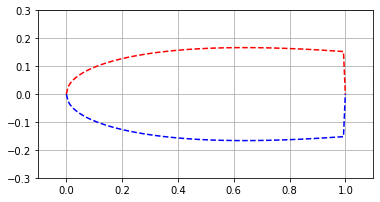

In [118]:
params = [.47]
airfoil = Airfoil2(params)
plot_airfoil(airfoil)

In [119]:
def avg_airfoil(airfoil_list, f=None, l=None):
    x = np.linspace(0.0, 1.0, 150)
    airfoils = np.zeros((len(airfoil_list), 2, 150))
    for i, airfoil in enumerate(airfoil_list):
        foil_up = airfoil.Z_up(x)
        foil_lo = airfoil.Z_lo(x)
        topmax = np.max(foil_up)
        airfoils[i,0] = foil_up * 1/(6*topmax)
        airfoils[i,1] = foil_lo * 1/(6*topmax)
    
    airfoils = np.mean(airfoils, axis=0)
    
    plt.plot(x, airfoils[0], 'r--', x, airfoils[1], 'b--')
    plt.xlim(-.1, 1.1)
    plt.ylim(-.3, .3)
    if l is not None:
        plt.xlabel(l)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    if f is None:
        plt.show()
    else:
        plt.savefig(f)
    plt.close()     

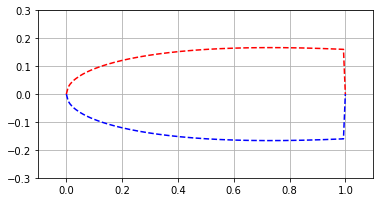

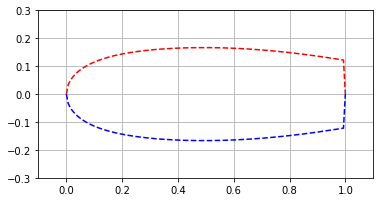

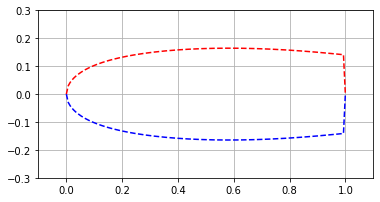

In [121]:
airfoils = []

params = [.41]
airfoil = Airfoil2(params)
plot_airfoil(airfoil)
airfoils += [airfoil]

# params = [0.397, 0.246, 0.294, 2.283, 0.611, 0.82]
params = [0.41, 0.266, 0.266, 2.255, 0.644, 0.54]
params = np.array(params)
airfoil = Airfoil(params)
plot_airfoil(airfoil)
airfoils += [airfoil]

avg_airfoil(airfoils)

In [172]:
class AirfoilMix(object):
    '''
    Credit for this class goes to
    https://github.com/mbodmer/libairfoil
    Airfoil defined by PARSEC Parameters
    '''
    def __init__(self, params):
        self.naca_params = params[0:1]
        self.parsec_params = params[1:7]
        self.mix = params[7]
        self.naca = Airfoil2(self.naca_params)
        self.parsec = Airfoil(self.parsec_params)

    def Z_up(self, X):
        naca_coords = self.naca.Z_up(X)
        parsec_coords = self.parsec.Z_up(X)
        naca_coords = naca_coords * 1/(6*np.max(naca_coords))
        parsec_coords = parsec_coords * 1/(6*np.max(parsec_coords))

        foil = self.mix * naca_coords + (1-self.mix) * parsec_coords
        # foil[-1] = 0
        return foil

    def Z_lo(self, X):
        return -self.Z_up(X)

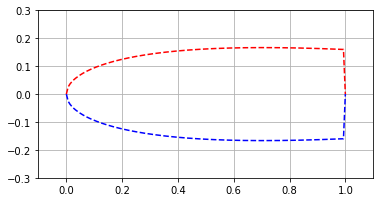

In [173]:
params = np.array([0.384, 0.402, 0.255, 0.281, 2.236, 0.646, 0.413, 0.54])
airfoil = AirfoilMix(params)
plot_airfoil(airfoil)

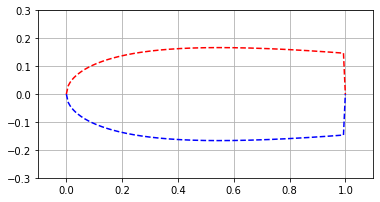

In [174]:
params = np.array([0.45, 0.41, 0.25, 0.28, 2.25, 0.65, .5, 0.3])
airfoil = AirfoilMix(params)
plot_airfoil(airfoil)

In [288]:
from __future__ import division
import numpy as np
import math
from scipy.interpolate import interp1d, splev, splrep, UnivariateSpline

class AirfoilInter(object):
    def __init__(self, params):
        params = np.array(params)
        assert params.size % 2 == 0
        xs = np.linspace(0,np.pi/2,1+params.size//2)
        xs = np.array([(0.5*(1.0-np.cos(x))) for x in xs])        
        self.x = np.hstack([xs,[1-e for e in xs[::-1][1:]]])
        self.y = np.zeros(params.size+1)
        for i in range(1,self.y.size):
            self.y[i] = self.y[i-1] + params[i-1]
        self.f = interp1d(self.x, self.y, kind=1)

    def Z_up(self, X):
        foil = self.f(X)
        foil[-1] = 0
        return foil

    def Z_lo(self, X):
        return -self.Z_up(X)

[0.0354, 0.0332, 0.0295, 0.0245, 0.0188, 0.013, 0.0077, 0.0033, 0.0, -0.0022, -0.0035, -0.0041, -0.0039, -0.0033, -0.0022, 0.0]


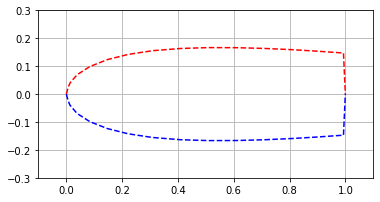

In [272]:
params = np.array([0.45, 0.41, 0.25, 0.28, 2.25, 0.65, .5, 0.3])
airfoil = AirfoilMix(params)

xs = np.linspace(0,np.pi/2,9)
xs = np.array([(0.5*(1.0-np.cos(x))) for x in xs])
xs = np.hstack([xs,[1-e for e in xs[::-1][1:]]])

ys = airfoil.Z_up(xs)
ys[-1] = ys[-2]
ys = [ ys[i+1] - ys[i] for i in range(len(ys)-1)]

print(list(np.around(ys, decimals=4)))

airfoil = AirfoilInter(ys)
plot_airfoil(airfoil)

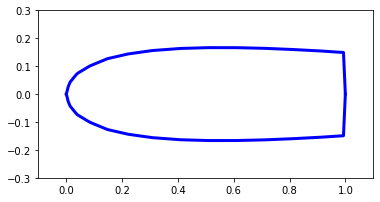

In [289]:
params = [0.0399, 0.0366, 0.029, 0.027, 0.0181, 0.0126, 0.0076, 0.0032, 0.0002, -0.002, -0.0034, -0.0039, -0.0036, -0.0032, -0.0022, 0.0005]
params = np.array(params)
airfoil = AirfoilInter(params)
plot_airfoil(airfoil, grid=False)

In [266]:
designs = [
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.035, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.031, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.026, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.02, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.014, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.033, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.034, 0.033, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.025, 0.019, 0.012, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.025, 0.019, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.034, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.034, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.033, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.028, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.033, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.023, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.029, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, -0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.025, 0.019, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.024, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.029, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.004, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.029, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.029, 0.024, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, -0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.035, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.029, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.029, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.029, 0.026, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.035, 0.035, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.024, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.024, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.029, 0.024, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.029, 0.024, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.025, 0.018, 0.012, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.036, 0.03, 0.024, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.025, 0.019, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.034, 0.03, 0.024, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.035, 0.029, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.024, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, -0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.035, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.035, 0.03, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.036, 0.03, 0.025, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.035, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.035, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.037, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.038, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, -0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.03, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.036, 0.035, 0.03, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.03, 0.026, 0.018, 0.012, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.038, 0.037, 0.03, 0.027, 0.019, 0.012, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.036, 0.035, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.035, 0.029, 0.026, 0.019, 0.013, 0.008, 0.003, -0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.03, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.035, 0.029, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.035, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.03, 0.026, 0.018, 0.012, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.03, 0.025, 0.018, 0.012, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.029, 0.026, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.036, 0.035, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.029, 0.025, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.03, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.03, 0.025, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.03, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.025, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.037, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.027, 0.018, 0.012, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.03, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.029, 0.025, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.039, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.038, 0.036, 0.03, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.039, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.039, 0.037, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.037, 0.037, 0.029, 0.026, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.03, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.037, 0.029, 0.026, 0.019, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, -0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.037, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.036, 0.029, 0.027, 0.018, 0.012, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.04, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.012, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.038, 0.036, 0.029, 0.026, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.001],
[0.039, 0.037, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.036, 0.029, 0.027, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.027, 0.018, 0.013, 0.007, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.026, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.039, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.036, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0],
[0.04, 0.037, 0.029, 0.027, 0.018, 0.013, 0.008, 0.003, 0.0, -0.002, -0.003, -0.004, -0.004, -0.003, -0.002, 0.0]
]

objs = [
0.4499,
0.5586,
0.4425,
0.4527,
0.4517,
0.4555,
0.4627,
0.4621,
0.4513,
0.451,
0.4497,
0.5604,
0.4518,
0.4594,
0.4511,
0.4508,
0.4387,
0.4478,
0.453,
0.4497,
0.4484,
0.4453,
0.4483,
0.4448,
0.4547,
0.4514,
0.447,
0.4439,
0.443,
0.4449,
0.4425,
0.4442,
0.4418,
0.441,
0.4405,
0.437,
0.4323,
0.4386,
0.4425,
0.4345,
0.437,
0.4344,
0.5491,
0.442,
0.4334,
0.4344,
0.4294,
0.4179,
0.4305,
0.4381,
0.427,
0.4273,
0.4275,
0.4241,
0.4238,
0.4182,
0.4206,
0.5334,
0.4331,
0.4206,
0.4179,
0.5343,
0.43,
0.4183,
0.4193,
0.4141,
0.4054,
0.4097,
0.4185,
0.4096,
0.424,
0.4106,
0.4056,
0.4022,
0.4081,
0.4237,
0.4202,
0.4021,
0.4134,
0.424,
0.4081,
0.4222,
0.4164,
0.4237,
0.4165,
0.422,
0.4152,
0.4077,
0.4112,
0.4036,
0.4006,
0.6208,
0.4175,
0.4363,
0.4132,
0.4168,
0.4135,
0.4186,
0.416,
0.4179,
0.412,
0.5498,
0.4095,
0.4172,
0.4119,
0.4029,
0.5351,
0.4102,
0.4014,
0.4211,
0.408,
0.4192,
0.4091,
0.4034,
0.4426,
0.4064,
0.3996,
0.3936,
0.3987,
0.5028,
0.4074,
0.3985,
0.5087,
0.4053,
0.3955,
0.416,
0.4058,
0.3971,
0.6278,
0.4049,
0.3986,
0.396,
0.4084,
0.4039,
0.3955,
0.3956,
0.4112,
0.4029,
0.5194,
0.4019,
0.4139,
0.4015,
0.4112,
0.4014,
0.414,
0.4014,
0.3964,
0.3942,
0.4132,
0.4,
0.3951,
0.3937,
0.3935,
0.4054,
0.3919,
0.513,
0.4109,
0.3985,
0.3929,
0.4082,
0.399,
0.3944,
0.3926,
0.3932,
0.3926,
0.5051,
0.3933,
0.5075,
0.6157,
0.504,
0.3943,
0.3932,
0.3944,
0.4146,
0.3947,
0.3945,
0.3963,
0.3932,
0.3934,
0.6366,
0.3927,
0.4112,
0.3917,
0.3908,
0.4107,
0.392,
0.3904,
0.4033,
0.3905,
0.3911,
0.3906,
0.3918,
0.4085,
0.3949,
0.39,
0.3935,
0.3909,
0.4064,
0.3938,
0.4075
]

In [274]:
def plot_anim(designs, objs):
    for i in range(len(designs)):
        params = designs[i]
        airfoil = AirfoilInter(np.array(params))
        iter = str(i+1)
        iter = '0'*(4-len(iter)) + iter
        filename = "../anim/interp" + iter + ".png"
        label = "Iter: " + iter + "    Obj: {:.4f}".format(objs[i])
        plot_airfoil(airfoil, f=filename, l=label)

In [275]:
plot_anim(designs, objs)